<a href="https://colab.research.google.com/github/carlogalli/colab-gpu/blob/main/gaballo-galli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.8/julia-1.8.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; Pkg.add("IJulia"); installkernel("Julia");'
jupyter kernelspec install $(jupyter kernelspec list | grep julia | tr -s ' ' | cut -d' ' -f3) --replace --name julia

After you have run the cell above this text, reload the page (Ctrl+R). Then run the cell below to make sure you are indeed using Julia.

In [1]:
# Run this cell tocheck if you're now running Julia: it will print the current version if so, and gives an error otherwise
VERSION

v"1.8.5"

In [ ]:
# Install packages (may take a couple of minutes)
using Pkg
Pkg.add(["PyPlot", "PyCall", "Optim", "Distributions", "Roots", "Printf", "QuadGK", "Random"]);

using PyPlot, PyCall, Optim, Distributions, Roots, Printf, QuadGK, Random;

function plot_style(fignum; 
	fs::Real=10, 				# fontsize singlegraph
	fs_title::Real=NaN,   				# fontsize title (defaults to fs)
	fs_legend::Real=NaN, 				# fontsize legend (defaults to fs)
	fs_label::Real=NaN, 				# fontsize label (defaults to fs)
	xticklabsize::Real=NaN, 	
	yticklabsize::Real=NaN, 	
	xlabel_coords::Tuple=(0.5, -0.1),
	ylabel_coords::Tuple=(-0.1, 0.5),
	title_coords::Tuple=(0.5, 1.05),
	legend_labelspacing::Real=0,	# vertical space between legend labels
	legend_columnspacing::Real=2, 					# spacing between columns
	legend_handlepad::Real=1,				# space between legend handle and text
	legend_loc=0,						# legend location (0=best)
	hl::Real=1, 					# legend handlelength
	legend_ncol=1,
	ldir_subplot::String="in",
	xtick_label_format::String="%.2f",
	ytick_label_format::String="%.2f", 
	xtick_number=NaN,
	ytick_number=NaN, 
	format_tick_labels::Bool=false,
	tick_direction="in",
	tick_rotation=0,
	xtick_rotation=NaN,
	ytick_rotation=NaN,
	tick_pad=4,
	tick_width=1,
	tick_length=4
	)

	fig = figure(fignum)
	axs = fig.axes
	fmt_x = matplotlib.ticker.FormatStrFormatter(xtick_label_format)
	fmt_y = matplotlib.ticker.FormatStrFormatter(ytick_label_format)

	if isnan(fs_legend); fs_legend=fs; end
	if isnan(fs_title); fs_title=fs; end
	if isnan(fs_label); fs_label=fs; end
	if isnan(xticklabsize); xticklabsize=fs-4; end
	if isnan(yticklabsize); yticklabsize=fs-4; end

	for i in 1:length(axs)
		ca = axs[i]
		
		ca.tick_params.("both", labelcolor = "k", direction = tick_direction, length = tick_length, width = tick_width, pad = tick_pad, colors = "k", rotation=tick_rotation)
		ca.tick_params.("x", labelsize = xticklabsize, rotation=(isnan(xtick_rotation) ? tick_rotation : xtick_rotation))
		ca.tick_params.("y", labelsize = yticklabsize, rotation=(isnan(ytick_rotation) ? tick_rotation : ytick_rotation))
		ca.xaxis.label.set_size(fs_label)
		ca.yaxis.label.set_size(fs_label)
		ca.xaxis.set_label_coords.(xlabel_coords[1], xlabel_coords[2])	    
		ca.yaxis.set_label_coords.(ylabel_coords[1], ylabel_coords[2])

		if format_tick_labels
			ca.xaxis.set_major_formatter(fmt_x)
			ca.yaxis.set_major_formatter(fmt_y)
		end
		
		if length(ca.get_title())>0 		# there is a title
			ca.title.set_size(fs_title)
			ca.title.set_y.(title_coords)
		end

		if isnan(xtick_number)==false
			xl, xh = ca.get_xlim()
			ca.xaxis.set_ticks(range(xl, stop=xh, length=xtick_number))
		end
		if isnan(ytick_number)==false
			yl, yh = ca.get_ylim()
			ca.yaxis.set_ticks(range(yl, stop=yh, length=ytick_number))
		end

		
		if isa(ca.get_legend_handles_labels()[2],Array{String})	# there is a legend			
			ca.legend(fontsize = fs_legend, handlelength = hl, frameon = false, labelspacing=legend_labelspacing, loc=legend_loc, ncol=legend_ncol, columnspacing=legend_columnspacing, handletextpad=legend_handlepad)
		end
	end
end

# Functions

In [11]:

struct Model{F}
    q::F
    θh::F
    θl::F

    τ_x::F
    σ_x::F
    σ_p::F

    h::F
    bcb_bar_coeff::F
    Rstar_coeff::F
end

function Model(; q::T=0.5, τ_x::T=1., θh::T=1., h::T=0.4, bcb_bar_coeff::T=1., Rstar_coeff::T=1.) where T<:Real
    θl = θh-h
    σ_x = T(1)/sqrt(τ_x)
    σ_p = σ_x/sqrt(T(2))

    return Model(q, θh, θl, τ_x, σ_x, σ_p, h, bcb_bar_coeff, Rstar_coeff)
end

sn_cdf(x::T) where T<:Real = cdf(Normal(T(0),T(1)), x)
sn_pdf(x::T) where T<:Real = pdf(Normal(T(0),T(1)), x)
sn_invcdf(x::T) where T<:Real = quantile(Normal(T(0),T(1)), x)

function bcb_bar_fn(m::Model, zz::Vector{T}) where T<:Real
    z_0_mkt, z_0_pub = zz
    bbar1 = m.bcb_bar_coeff * (1-sn_cdf((m.θl-z_0_pub)/m.σ_x))
    bbar2 = 1-sn_cdf((m.θh-z_0_pub)/m.σ_x)
    return min(bbar1, bbar2)
end

function s_bounds_fn(m::Model, θ::T, zz::Vector{T}) where T<:Real
    z_0_mkt, z_0_pub = zz
    z_0 = z_0_mkt

    s_lb_l = sn_cdf((m.θl-z_0)/m.σ_x)
    
    bcb_lb_l = bcb_unbounded_fn(m, m.θl, s_lb_l, z_0_pub)

    s_lb_h = sn_cdf((m.θh-z_0)/m.σ_x)
    
    bcb_lb_h = bcb_unbounded_fn(m, m.θh, s_lb_h, z_0_pub)

    ~, i = findmin([bcb_lb_l, bcb_lb_h])
    if i==1 && θ==m.θh
        s_lb = bcb_lb_l+sn_cdf((m.θh-z_0_pub)/m.σ_x)
    elseif i==2 && θ==m.θl
        s_lb = bcb_lb_h+sn_cdf((m.θl-z_0_pub)/m.σ_x)
    else
        s_lb = sn_cdf((θ-z_0)/m.σ_x)
    end

    bcb_bar = bcb_bar_fn(m, zz)

    s_ub = min(1., bcb_bar + sn_cdf((θ-z_0_pub)/m.σ_x))
    return s_lb, s_ub
end

function xhat_fn(m::Model, θ::Real, S::Real)
    xhat = θ - m.σ_x*sn_invcdf(S)
    return xhat
end

function bcb_unbounded_fn(m::Model, θ::Real, S::Real, z::Real)
    return S - sn_cdf((θ-z)/m.σ_x)
end

function bcb_fn(m::Model, θ::T, S::T, zz::Vector{T}; bcb_test::T=NaN) where T<:Real
    z_0_mkt, z_0_pub = zz
    s_lb, s_ub = s_bounds_fn(m, θ, zz)
    
    bcb_bar = bcb_bar_fn(m, zz)

    test = 0
    if S <= s_lb+test
        return T(0)
    
    elseif s_lb+test < S <= s_ub
        if bcb_unbounded_fn(m, θ, S, z_0_pub) < 0
            #return bcb_unbounded_fn(m, θ, S, z_0_mkt)*0.5
            return T(0)
        else
            # return bcb_unbounded_fn(m, θ, S, max(z_0_pub, z_0_mkt))
            return bcb_unbounded_fn(m, θ, S, z_0_pub)
        end

    elseif S > s_ub
        # Check if there would be a jump in R in the wrong direction
        # if θ-m.σ_x*sn_invcdf(S-bcb_bar) > z_0_mkt
        # return T(0)
            # return S-sn_cdf((θ-z_0_mkt)/m.σ_x)
            # return bcb_bar
        if z_0_mkt <= z_0_pub
            if isnan(bcb_test)
                # bcb_test = s_ub-sn_cdf((θ-z_0_mkt)/m.σ_x)
                bcb_test_h = s_bounds_fn(m, m.θh, zz)[2]-sn_cdf((m.θh-z_0_mkt)/m.σ_x)
                bcb_test_l = s_bounds_fn(m, m.θl, zz)[2]-sn_cdf((m.θl-z_0_mkt)/m.σ_x)
                bcb_test = min(bcb_test_h, bcb_test_l)
                #bcb_test = bcb_test + 1/3*(S-s_ub)
            end
            return min(bcb_test, bcb_bar)
            # return bcb_bar
            # return min(bcb_unbounded_fn(m, θ, S, z_0_pub), bcb_bar)
        
        elseif z_0_mkt > z_0_pub
            return min(bcb_unbounded_fn(m, θ, S, z_0_pub), bcb_bar)
        end
    end
end


function xhat_ap_fn(m::Model, θ::T, S::T, zz::Vector{T}) where T<:Real
    bcb = bcb_fn(m, θ, S, zz)
    out = θ-m.σ_x*sn_invcdf(S-bcb)
    return out
end

function rp_fn(m::Model, z::T, σ::T) where T<:Real
    pdf_marginal = (m.q*sn_pdf((m.θh-z)/σ) + (1-m.q)*sn_pdf((m.θl-z)/σ)) / σ
    if pdf_marginal == T(0)
        out = ifelse(z≈T(Inf), T(1), T(0))
    else
        out = sn_pdf((m.θh-z)/σ)*m.q/σ / pdf_marginal
    end

    # x = (1-m.q)/m.q*sn_pdf((m.θl-z)/σ)/sn_pdf((m.θh-z)/σ)
    # out = 1/(1+x)
    return out
end

function p_to_z_fn(m, p, σ)
    z = (m.θh+m.θl)/2 - σ^2/(m.θh-m.θl)*log((1-p)/p*m.q/(1-m.q))
    return z
end

function rp_mkt_fn(m::Model, θ::T, S::T, zz::Vector{T}) where T<:Real
    z_0_mkt, z_0_pub = zz
    s_lb_h, s_ub_h = s_bounds_fn(m, m.θh, zz)

    s_lb, s_ub = s_bounds_fn(m, θ, zz)
    z_aps = xhat_ap_fn(m, θ, S, zz)
    bcb_bar = bcb_bar_fn(m, zz)

    z_nofullrev_l = xhat_ap_fn(m, m.θh, 1., zz)
    z_nofullrev_h = xhat_ap_fn(m, m.θh, min(s_ub_h+1e-7,1.), zz)

    rp_noaps_h = rp_fn(m, xhat_ap_fn(m, m.θh, s_lb_h, zz), m.σ_p)
    rp_star = rp_fn(m, z_0_pub, m.σ_x)

    if S <= s_lb
        # R < R*, APs = 0, standard learning with wedge
        out = rp_fn(m, z_aps, m.σ_p)
        if rp_star < out < rp_noaps_h
            out = T(0)
        end
        
    elseif s_lb < S <= s_ub
        # R would be above R*, APs are interior and R=R*
        out = rp_fn(m, z_aps, m.σ_x)

    elseif s_ub < S
        # APs are constrained by bcb_bar, R > R*, we go back to standard learning with wedge, no revelation
        if z_nofullrev_l <= z_aps <= z_nofullrev_h
            out = rp_fn(m, z_aps, m.σ_p)
        else
            out = T(0)
        end
    end
    return out
end

function rp_ext_fn(m::Model, θ::T, S::T, zz::Vector{T}) where T<:Real
    z_0_mkt, z_0_pub = zz
    s_lb_h, s_ub_h = s_bounds_fn(m, m.θh, zz)

    s_lb, s_ub = s_bounds_fn(m, θ, zz)
    z_aps = xhat_ap_fn(m, θ, S, zz)
    bcb_bar = bcb_bar_fn(m, zz)

    z_nofullrev_l = xhat_ap_fn(m, m.θh, 1., zz)
    z_nofullrev_h = xhat_ap_fn(m, m.θh, min(s_ub_h+1e-7,1.), zz)

    rp_noaps_h = rp_fn(m, xhat_ap_fn(m, m.θh, s_lb_h, zz), m.σ_p)
    rp_star = rp_fn(m, z_0_pub, m.σ_x)

    if S <= s_lb
        # R < R*, APs = 0, standard learning with wedge
        out = rp_fn(m, z_aps, m.σ_x)
        if rp_star < out < rp_noaps_h
            out = T(0)
        end
        
    elseif s_lb < S <= s_ub
        # R would be above R*, APs are interior and R=R*
        out = rp_fn(m, z_aps, m.σ_x)

    elseif s_ub < S
        # APs are constrained by bcb_bar, R > R*, we go back to standard learning with wedge, no revelation
        if z_nofullrev_l <= z_aps <= z_nofullrev_h
            out = rp_fn(m, z_aps, m.σ_x)
        else
            out = T(0)
        end
    end
    return out
end



function R_fn(m::Model, θ::T, S::T) where T<:Real
    z = xhat_fn(m, θ, S)
    p = rp_fn(m, z, m.σ_p)
    return 1/(p*(m.θh-m.θl)+m.θl)
end
function R_fn(m::Model, z::T) where T<:Real
    p = rp_fn(m, z, m.σ_p)
    return 1/(p*(m.θh-m.θl)+m.θl)
end

function R_fn(m::Model, θ::T, S::T, zz::Vector{T}) where T<:Real
    p = rp_mkt_fn(m, θ, S, zz)
    return 1/(p*(m.θh-m.θl)+m.θl)
end

function R_ext_fn(m::Model, θ::T, S::T) where T<:Real
    z = xhat_fn(m, θ, S)
    p = rp_fn(m, z, m.σ_x)
    return 1/(p*(m.θh-m.θl)+m.θl)
end
function R_ext_fn(m::Model, z) where T<:Real
    p = rp_fn(m, z, m.σ_x)
    return 1/(p*(m.θh-m.θl)+m.θl)
end

function R_ext_fn(m::Model, θ, S, zz::Vector{Real})
    p = rp_ext_fn(m, θ, S, z_hat, bcb_bar=bcb_bar)
    return 1/(p*(m.θh-m.θl)+m.θl)
end


function profit_cb_fn(m::Model, θ::Real, S::Real, zz::Vector)
    bcb = bcb_fn(m, θ, S, zz)
    R = R_fn(m, θ, S, zz)
    return bcb * (R*θ-1)
end


function get_density_obj(v; nbins=100)
    pdf_v = normalize(fit(Histogram, v, nbins=nbins), mode=:pdf)
    grid = collect(pdf_v.edges[1][2:end])
    weights = pdf_v.weights./sum(pdf_v.weights)
    if abs(sum(weights) - 1) > 1e-6
        error("weights do not sum to 1")
    end
    return grid, weights
end

function pdf_itp(z, grid, weights)
    if z < grid[1] || z > grid[end]
        return 0.
    else
        return interpolate((grid,), weights, Gridded(Linear()))(z)
    end
end

pdf_itp (generic function with 1 method)

# Plotting

In [12]:
# Define grids and colors

sgrid = 0:0.0001:1
ns = length(sgrid)
x = 0.8; col_gray = (x,x,x)


c_pub = "b"
c_mkt = "orange"
x = 0.8; c0 = (x,x,x)
lw1 = 1.
lw2 = 0.5

0.5

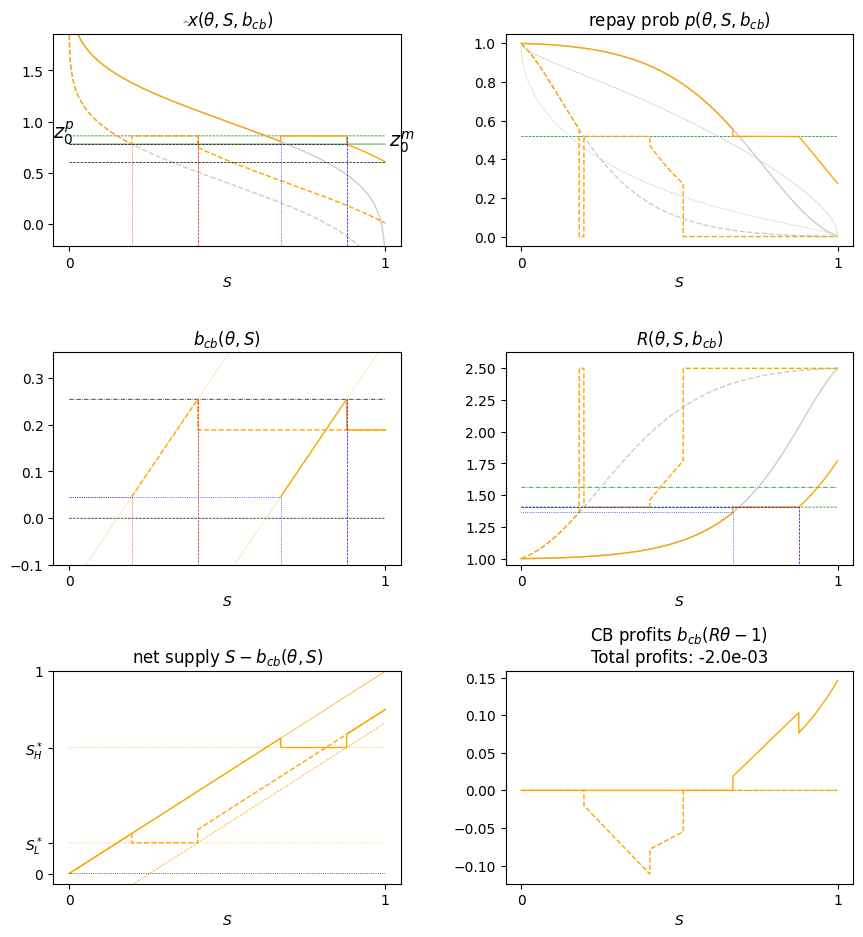

In [13]:
function f1()

    m = Model(τ_x=5., q=0.4, θh=1., h=0.6, bcb_bar_coeff=0.3, Rstar_coeff=0.9)


    Rprior = 1/(m.q*m.θh + (1-m.q)*m.θl)
    Rstar = Rprior*m.Rstar_coeff
    Pstar = 1/Rstar
    rpstar = (Pstar-m.θl)/(m.θh-m.θl)

    z0m = find_zero(z->R_fn(m,z)-Rstar, (-10, 10))
    z0p = find_zero(z->R_ext_fn(m,z)-Rstar, (-10, 10))
    zzs = [z0m; z0p]

    bcb_ub = bcb_bar_fn(m, zzs)

    S_lb_l, S_ub_l = s_bounds_fn(m, m.θl, zzs)
    S_lb_h, S_ub_h = s_bounds_fn(m, m.θh, zzs)

    S_lb_h - sn_cdf((m.θh-z0p)/m.σ_x)
    S_lb_l - sn_cdf((m.θl-z0p)/m.σ_x)

    fignum = 1
    figure(fignum, figsize=(10,10))
    clf()
    rows = 3; cols = 2
    fig, axs = subplots(rows, cols, num=fignum, clear=true)

    sca(axs[1,1])
    title(L"\widehat x(\theta, S, b_{cb})")
    plot(sgrid, ones(ns)*z0m, "-g", lw=lw2)
    plot(sgrid, ones(ns)*z0p, "--g", lw=lw2)
    # plot(sgrid, ones(ns)*zb_high, "-.k", lw=lw2)
    # plot(sgrid, ones(ns)*zb_low, "-.k", lw=lw2)
    text(1.01, z0m-0.025, L"z_0^m", fontsize=14)
    text(-0.05, z0p-0.025, L"z_0^p", fontsize=14)
    plot(sgrid, [xhat_fn(m,m.θh,S) for S in sgrid], "-", color=c0, lw=lw1)
    plot(sgrid, [xhat_fn(m,m.θl,S) for S in sgrid], "--", color=c0, lw=lw1)
    plot(sgrid, [xhat_ap_fn(m, m.θh, S, zzs) for S in sgrid], "-", color=c_mkt, lw=lw1, label=L"mkt, $\theta^H$")
    plot(sgrid, [xhat_ap_fn(m, m.θl, S, zzs) for S in sgrid], "--", color=c_mkt, lw=lw1, label=L"mkt, $\theta^L$")
    ylim(min(z0m, z0p)-1, max(z0m, z0p)+1)
    plot((S_lb_l, S_lb_l), (-10, xhat_fn(m, m.θl, S_lb_l)), ":r", lw=lw2)
    plot((S_ub_l, S_ub_l), (-10, z0p), "--r", lw=lw2)
    plot((S_lb_h, S_lb_h), (-10, xhat_fn(m, m.θh, S_lb_h)), ":b", lw=lw2)
    plot((S_ub_h, S_ub_h), (-10, z0p), "--b", lw=lw2)
    plot((0, S_ub_h), (xhat_ap_fn(m, m.θh, S_ub_h+1e-7, zzs), xhat_ap_fn(m, m.θh, S_ub_h+1e-7, zzs)), "--k", lw=lw2)
    plot((0, 1), (xhat_ap_fn(m, m.θh, 1., zzs), xhat_ap_fn(m, m.θh, 1., zzs)), "--k", lw=lw2)


    sca(axs[2,1])
    title(L"b_{cb}(\theta,S)")
    plot(sgrid, zeros(ns), "--k", lw=lw2)
    plot(sgrid, bcb_ub*ones(ns), "-.k", lw=lw2, label=L"\overline b_{cb}")
    bcb_h = [bcb_fn(m, m.θh, S, zzs) for S in sgrid]
    bcb_l = [bcb_fn(m, m.θl, S, zzs) for S in sgrid]
    # plot(sgrid, bcb_h, "-", color=c_mkt, lw=lw1)
    # plot(sgrid, bcb_l, "--", color=c_mkt, lw=lw1)
    plot(sgrid[bcb_h.>0], bcb_h[bcb_h.>0], "-", color=c_mkt, lw=lw1)
    plot(sgrid[bcb_l.>0], bcb_l[bcb_l.>0], "--", color=c_mkt, lw=lw1)
    plot(sgrid, [bcb_unbounded_fn(m, m.θh, S, z0p) for S in sgrid], color=c_mkt, ":", lw=lw2)
    plot(sgrid, [bcb_unbounded_fn(m, m.θl, S, z0p) for S in sgrid], color=c_mkt, ":", lw=lw2)
    plot((S_lb_l, S_lb_l), (-10, bcb_unbounded_fn(m, m.θl, S_lb_l, z0p)), ":r", lw=lw2)
    plot((S_ub_l, S_ub_l), (-10, bcb_unbounded_fn(m, m.θl, S_ub_l, z0p)), "--r", lw=lw2)
    plot((S_lb_h, S_lb_h), (-10, bcb_unbounded_fn(m, m.θh, S_lb_h, z0p)), ":b", lw=lw2)
    plot((S_ub_h, S_ub_h), (-10, bcb_unbounded_fn(m, m.θh, S_ub_h, z0p)), "--b", lw=lw2)
    plot((0,S_lb_l), (bcb_unbounded_fn(m, m.θl, S_lb_l, z0p), bcb_unbounded_fn(m, m.θl, S_lb_l, z0p)), ":r", lw=lw2)
    plot((0,S_lb_h), (bcb_unbounded_fn(m, m.θh, S_lb_h, z0p), bcb_unbounded_fn(m, m.θh, S_lb_h, z0p)), ":b", lw=lw2)
    ylim(-0.1, bcb_ub+0.1)



    sca(axs[3,1])
    title(L"net supply $S-b_{cb}(\theta,S)$")
    # plot(sgrid[bcb_h.>0], sgrid[bcb_h.>0].-bcb_h[bcb_h.>0], "-", color=c_mkt, lw=lw1)
    # plot(sgrid[bcb_l.>0], sgrid[bcb_l.>0].-bcb_l[bcb_l.>0], "--", color=c_mkt, lw=lw1)
    plot(sgrid, sgrid.-bcb_h, "-", color=c_mkt, lw=lw1)
    plot(sgrid, sgrid.-bcb_l, "--", color=c_mkt, lw=lw1)
    plot(sgrid, sgrid.-[bcb_unbounded_fn(m, m.θh, S, z0p) for S in sgrid], color=c_mkt, ":", lw=lw2)
    plot(sgrid, sgrid.-[bcb_unbounded_fn(m, m.θl, S, z0p) for S in sgrid], color=c_mkt, ":", lw=lw2)
    plot(sgrid, sgrid, color=c_mkt, "-", lw=lw2)
    plot(sgrid, sgrid.-bcb_ub, color=c_mkt, "--", lw=lw2)
    plot(sgrid, zeros(ns), ":k", lw=lw2)
    Sstar_l = sn_cdf((m.θl-z0p)/m.σ_x)
    Sstar_h = sn_cdf((m.θh-z0p)/m.σ_x)
    yticks([0; Sstar_l; Sstar_h; 1], [L"0"; L"S^*_L"; L"S^*_H"; L"1"])
    ylim(-0.05, 1)


    sca(axs[1,2])
    title(L"repay prob $p(\theta,S,b_{cb})$")
    # plot(sgrid, ones(ns)*rp_fn(m, z0m, m.σ_p), ":k", lw=lw2)
    plot(sgrid, ones(ns)*rpstar, "--g", lw=lw2)
    # plot(sgrid, ones(ns)*rp_fn(m, zb_high, m.σ_p), ":k", lw=lw2)
    plot(sgrid, [rp_fn(m, xhat_fn(m,m.θh,S), m.σ_p) for S in sgrid], "-", color=c0, lw=lw1)
    plot(sgrid, [rp_fn(m, xhat_fn(m,m.θl,S), m.σ_p) for S in sgrid], "--", color=c0, lw=lw1)
    plot(sgrid, [rp_fn(m, xhat_fn(m,m.θh,S), m.σ_x) for S in sgrid], "-", color=c0, lw=lw2)
    plot(sgrid, [rp_fn(m, xhat_fn(m,m.θl,S), m.σ_x) for S in sgrid], "--", color=c0, lw=lw2)
    plot(sgrid, [rp_mkt_fn(m, m.θh, S, zzs) for S in sgrid], "-", color=c_mkt, lw=lw1)
    plot(sgrid, [rp_mkt_fn(m, m.θl, S, zzs) for S in sgrid], "--", color=c_mkt, lw=lw1)


    sca(axs[2,2])
    title(L"R(\theta,S,b_{cb})")
    plot(sgrid, Rstar*ones(ns), "--g", lw=lw2)
    plot(sgrid, Rprior*ones(ns), "-.g", lw=lw2)
    plot(sgrid, [R_fn(m,m.θh,S) for S in sgrid], "-", color=c0, lw=lw1)
    plot(sgrid, [R_fn(m,m.θl,S) for S in sgrid], "--", color=c0, lw=lw1)
    # plot(sgrid, [R_fn(m,m.θh,S-bcb_fn(m, m.θh, S, z0m, z0p, bcb_bar=bcb_ub)) for S in sgrid], "-", color=c0, lw=lw2)
    # plot(sgrid, [R_fn(m,m.θl,S-bcb_fn(m, m.θl, S, z0m, z0p, bcb_bar=bcb_ub)) for S in sgrid], "--", color=c0, lw=lw2)
    # plot(sgrid, [R_ext_fn(m,m.θh,S) for S in sgrid], "-", color=c0, lw=lw1)
    # plot(sgrid, [R_ext_fn(m,m.θl,S) for S in sgrid], "--", color=c0, lw=lw1)
    plot(sgrid, [R_fn(m, m.θh, S, zzs) for S in sgrid], "-", color=c_mkt, lw=lw1)
    plot(sgrid, [R_fn(m, m.θl, S, zzs) for S in sgrid], "--", color=c_mkt, lw=lw1)
    plot((S_lb_h, S_lb_h), (0, R_fn(m, m.θh, S_lb_h, zzs)), ":b", lw=lw2)
    plot((0, S_lb_h), (R_fn(m, m.θh, S_lb_h, zzs), R_fn(m, m.θh, S_lb_h, zzs)), ":b", lw=lw2)
    plot((S_ub_h, S_ub_h), (0, R_fn(m, m.θh, min(1,S_ub_h+1e-6), zzs)), "--b", lw=lw2)
    plot((0, S_ub_h), (R_fn(m, m.θh, min(1,S_ub_h+1e-6), zzs), R_fn(m, m.θh, min(1,S_ub_h+1e-6), zzs)), "--b", lw=lw2)
    ylim(1/m.θh*0.95, 1/m.θl*1.05)


    sca(axs[3,2])
    title(L"CB profits $b_{cb}(R\theta-1)$")
    π_h = [profit_cb_fn(m, m.θh, S, zzs) for S in sgrid]
    π_l = [profit_cb_fn(m, m.θl, S, zzs) for S in sgrid]
    π_tot = mean(m.q*π_h+(1-m.q)*π_l)
    title(L"CB profits $b_{cb}(R\theta-1)$"*"\n"*@sprintf("Total profits: %.1e", π_tot))
    plot(sgrid, zeros(ns), ":k", lw=lw2)
    plot(sgrid, π_h, "-", color=c_mkt, lw=lw1)
    plot(sgrid, π_l, "--", color=c_mkt, lw=lw1)

    for i in 1:rows*cols
        sca(axs[i])
        xlabel(L"S")
        xticks([0,1])
    end
end

f1()
subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1, wspace=0.3, hspace=0.5)